In [15]:
import pandas as pd
import numpy as np
import os
import re
import sys
import datetime
import apertium

sys.path.append('../python_scripts/')
sys.path.append('../ML')
from duolingo_hlr import *
from bulkTranslate import *
from init_lipstick import *

In [3]:
def test_hist_column(gota: pd.DataFrame):
    """Test whether performance columns exist in gota and create them else"""
    try:
        gota['seen_hist']
    except KeyError:
        print("Creating column 'seen_hist'")
        gota['seen_hist'] = 0    

    try:
        gota['right_hist']
    except KeyError:
        print("Creating column 'right_hist'")
        gota['right_hist'] = 0

    return gota

def update_performance(lipstick : pd.DataFrame, iw : str, perf : float):
    """Update times the entry iw was practice and the performance"""
    lipstick.loc[iw, 'history_seen'] += 1
    lipstick.loc[iw, 'history_correct']+= perf
    lipstick.loc[iw, 'p_recall'] = lipstick.loc[iw, 'history_seen'] / lipstick.loc[iw, 'history_correct']
    return lipstick

def update_timedelta(lipstick : pd.DataFrame, iw : str):
    """Update last practice timestamp and timedelta"""
    today = int(datetime.datetime.timestamp(datetime.datetime.today()))
    lipstick.loc[iw, 'timestamp'] = today
    lipstick.delta = lipstick.timestamp - lipstick.timestamp.min()
    return lipstick

In [212]:
def set_lip(gota : pd.DataFrame, flag_lexeme = False):
    """Provisional simple initialization of lipstick from GOTA. 
        Attrs:
        ------
        p_recall : truth recall probability = history_correct/history_correct
        timestamp : last time practice timestamp
        delta : timedelta w.r.t. most unpracticed word (with minimum timestamp)
        user_id : user name
        learning_language: target language
        ui_language: user reference language
        lexeme_id: word in target language, lexeme in the future?
        word_id: word in reference language
        lexeme_string: lexeme tag with grammatical/syntactical information, not implemented yet
        history_seen: times the word has been practiced from initialization
        history_correct: times the translation has been correctly recalled from initialization
        session_seen: practice times in last session (not implemented)
        session_correct: correctly recalled times in last session (not implemented)

        Additional attrs:
        ------
        p_pred: predicted probability from hlr model (not in initialization)
    """
    cols0 = ['lexeme_id', 'translated_word', 'timestamp', 'history_seen', 'history_correct']

    lear_lang = gota.columns[0]
    ui_lang = gota.columns[1]
    timest = gota.creation_time # .apply(lambda d: datetime.datetime.strptime(d, '%Y-%m-%d %H:%M:%S.%f')).apply(lambda dt : int(datetime.datetime.timestamp(dt)))

    delta = timest - np.min(timest)
    # ptruth = ((gota.right_hist ) / gota.seen_hist).fillna(0)   # Legacy from using GOTA as DB corpus with updatePerformance.py
    ptruth = pd.Series(np.zeros_like(timest))  # Initialize on 0, also for seen and correct attrs.
    lipstick = pd.DataFrame({'p_recall':ptruth})
        
    lipstick['timestamp'] = timest
    lipstick['delta'] = delta
    lipstick['user_id'] = 'pablo'  # Will be customizable later
    lipstick['learning_language'] = lear_lang
    lipstick['ui_language'] = ui_lang
    lipstick['word_ll'] = gota[lear_lang]
    lipstick['word_ul'] = gota[ui_lang]
    
    if flag_lexeme:
        lexeme = []
        for wd in lipstick.word_ll:
            tagSplit = str(apertium.tag(lear_lang, wd)[0]).split('/')
            lexeme.append(tagSplit[0] + '/' + tagSplit[1])
    else:
        lexeme = 'lernt/lernen<vblex><pri><p3><sg>' 
        
    lipstick['lexeme_string'] = lexeme
    lipstick['history_seen'] = ptruth  
    lipstick['history_correct'] = ptruth  
    lipstick['session_seen'] = ptruth  
    lipstick['session_correct'] = ptruth
    
    return lipstick

# Import GOTA 

In [9]:
gota_path = '/Users/pabloherrero/Documents/ManHatTan/GOTAs/Die_Verwandlung.got'
gota = pd.read_csv(gota_path, index_col=0)
timest = gota.creation_time.apply(lambda d: datetime.datetime.strptime(d, '%Y-%m-%d %H:%M:%S.%f')).apply(lambda dt : int(datetime.datetime.timestamp(dt)))
gota.creation_time = timest

In [19]:
lipstick = set_lip(gota)

                   de             en  creation_time  seen_hist  right_hist
0          Ungeziefer         vermin     1584895152          0         0.0
1       Versteifungen     stiffeners     1584895152          2         2.0
2              Umfang          scope     1584895152          3         1.0
3          flimmerten      flickered     1584895152          0         0.0
4            versehen     isprovided     1584895152          0         0.0
5        Fensterblech    Windowsheet     1584895152          0         0.0
6      undurchführbar  impracticable     1584895152          1         1.0
7          schaukelte         rocked     1584895152          1         1.0
8              Jucken        itching     1584895152          0         0.0
9                Pult          panel     1584895152          0         0.0
10             Zeiger        pointer     1584895152          0         0.0
11       Donnerwetter           Gosh     1584895152          3         3.0
12           Rückgrat    

## Tag lexeme with apertium

In [61]:
wd = lipstick.iloc[88].word_ll

In [83]:
analy = apertium.analyze('de', wd)[0]
reading = analy.readings[0][0]
analy

Gleichgültigkeit/Gleichgültigkeit<n><f><sg><nom>/Gleichgültigkeit<n><f><sg><gen>/Gleichgültigkeit<n><f><sg><dat>/Gleichgültigkeit<n><f><sg><acc>/gleichgültigkeit<n><f><sg><nom><lower>/gleichgültigkeit<n><f><sg><gen><lower>/gleichgültigkeit<n><f><sg><dat><lower>/gleichgültigkeit<n><f><sg><acc><lower>/gleichgültigkeit<n><f><sg><nom><lower>/gleichgültigkeit<n><f><sg><gen><lower>/gleichgültigkeit<n><f><sg><dat><lower>/gleichgültigkeit<n><f><sg><acc><lower>

In [82]:
LU =apertium.tag('de', wd)[0]
LU

Gleichgültigkeit/Gleichgültigkeit<n><f><sg><nom>/Gleichgültigkeit<n><f><sg><gen>/Gleichgültigkeit<n><f><sg><dat>/Gleichgültigkeit<n><f><sg><acc>

In [68]:
tagSplit = str(LU).split('/')
lexeme = tagSplit[0] + '/' + tagSplit[1]
lexeme

'Achseln/Achsel<n><f><pl><nom>'

## Now for all entries

In [76]:
full_lexeme = lipstick.word_ll.apply(lambda wd: apertium.tag('de', wd)[0])
lex = full_lexeme.apply(lambda lu: (str(lu).split('/'))[0] + '/' + (str(lu).split('/'))[1] )
# .apply(lambda d: datetime.datetime.strptime(d, '%Y-%m-%d %H:%M:%S.%f')).apply(lambda dt : int(datetime.datetime.timestamp(dt)))

In [77]:
lex

0                  Ungeziefer/Ungeziefer<n><nt><sg><nom>
1               Versteifungen/Versteifung<n><f><pl><nom>
2                           Umfang/Umfang<n><m><sg><nom>
3                flimmerten/flimmern<vblex><pii><p3><pl>
4                          versehen/versehen<vblex><inf>
5      Fensterblech/Fenster<n><nt><sg><cmp>+blech<n><...
6               undurchführbar/undurchführbar<adj><sint>
7               schaukelte/schaukeln<vblex><pii><p3><sg>
8                              Jucken/Jucken<vblex><inf>
9                              Pult/Pult<n><nt><sg><nom>
10                          Zeiger/Zeiger<n><m><sg><nom>
11                         Donnerwetter/Donnerwetter<ij>
12                     Rückgrat/Rückgrat<n><nt><sg><nom>
13                       Einwände/Einwand<n><m><pl><nom>
14                          arbeitsscheue/*arbeitsscheue
15                                    derart/derart<adv>
16                          ausführlich/ausführlich<adv>
17                            F

In [75]:
lexeme = []
for wd in lipstick.word_ll:
    tagSplit = str(apertium.tag('de', wd)[0]).split('/')
    lexeme.append(tagSplit[0] + '/' + tagSplit[1])
lexeme

['Ungeziefer/Ungeziefer<n><nt><sg><nom>',
 'Versteifungen/Versteifung<n><f><pl><nom>',
 'Umfang/Umfang<n><m><sg><nom>',
 'flimmerten/flimmern<vblex><pii><p3><pl>',
 'versehen/versehen<vblex><inf>',
 'Fensterblech/Fenster<n><nt><sg><cmp>+blech<n><nt><sg><nom><lower>',
 'undurchführbar/undurchführbar<adj><sint>',
 'schaukelte/schaukeln<vblex><pii><p3><sg>',
 'Jucken/Jucken<vblex><inf>',
 'Pult/Pult<n><nt><sg><nom>',
 'Zeiger/Zeiger<n><m><sg><nom>',
 'Donnerwetter/Donnerwetter<ij>',
 'Rückgrat/Rückgrat<n><nt><sg><nom>',
 'Einwände/Einwand<n><m><pl><nom>',
 'arbeitsscheue/*arbeitsscheue',
 'derart/derart<adv>',
 'ausführlich/ausführlich<adv>',
 'Faust/Faust<n><f><sg><nom>',
 'Einbildung/Einbildung<n><f><sg><nom>',
 'Vorbote/Vorbote<n><m><sg><nom>',
 'tüchtigen/tüchtig<adj><sint><m><sg><gen><st>',
 'Willkür/Willkür<n><f><sg><nom>',
 'Zuversicht/Zuversicht<n><f><sg><nom>',
 'Munterkeit/Munterkeit<n><f><sg><nom>',
 'Krach/Krach<n><m><sg><nom>',
 'endgültig/endgültig<adv>',
 'erstarrte/erstarr

##### A bit inefficient...

### Store lipstick..

In [13]:
write_lip(gota_path, lipstick)

Created LIPSTICK file /Users/pabloherrero/Documents/ManHatTan/LIPSTICK/Die_Verwandlung.lip


'/Users/pabloherrero/Documents/ManHatTan/LIPSTICK/Die_Verwandlung.lip'

In [4]:
iw, perf = 71, -1
gota['seen_hist'].loc[iw] += 1
gota['right_hist'].loc[iw] += perf

gota.iloc[iw-3:iw+2]

/Users/pabloherrero/anaconda3/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,de,en,creation_time,seen_hist,right_hist
68,Einwirkungen,actions,2020-03-22 17:39:12.011106,1,1.0
69,entbehren,dispense,2020-03-22 17:39:12.011106,1,1.0
70,Trotz,Despite,2020-03-22 17:39:12.011106,1,-1.0
71,Entschlusse,resolve,2020-03-22 17:39:12.011106,2,0.0
72,unweigerlich,inevitably,2020-03-22 17:39:12.011106,1,1.0


In [14]:
write_gota(gota_path, gota)

Created GOTA file /Users/pabloherrero/Documents/ManHatTan/GOTAs/Die_Verwandlung.got


'/Users/pabloherrero/Documents/ManHatTan/GOTAs/Die_Verwandlung.got'

# Init LIPSTICK (Siddhartha)

In [2]:
gota_path = '/Users/pabloherrero/Documents/ManHatTan/GOTAs/Notizen aus _Siddhartha_ eine indische Dichtung (German Edition)_.got'
gota = pd.read_csv(gota_path, index_col=0)
gota

,de,en,creation_time
0,"struppiger bettler,",shaggy beggar,1586602442
1,"griffel,",stylus,1586602442
2,laub,leaves,1586602442
3,biegsam,flexible,1586602442
4,müdgewordenen,müdgewordenen,1586602442
5,wohlergehen,wohlergehen,1586602442
6,dienerschaft,diener economy,1586602442
7,predigt,preaches,1586602442
8,allmählich,gradually,1586602442
9,töpfers,potter,1586602442


In [3]:
lipstick = set_lip(gota)
lipstick

,p_recall,timestamp,delta,user_id,learning_language,ui_language,lexeme_id,word_id,lexeme_string,history_seen,history_correct,session_seen,session_correct
0,0,1586602442,0,pablo,de,en,"struppiger bettler,",shaggy beggar,lernt/lernen<vblex><pri><p3><sg>,0,0,0,0
1,0,1586602442,0,pablo,de,en,"griffel,",stylus,lernt/lernen<vblex><pri><p3><sg>,0,0,0,0
2,0,1586602442,0,pablo,de,en,laub,leaves,lernt/lernen<vblex><pri><p3><sg>,0,0,0,0
3,0,1586602442,0,pablo,de,en,biegsam,flexible,lernt/lernen<vblex><pri><p3><sg>,0,0,0,0
4,0,1586602442,0,pablo,de,en,müdgewordenen,müdgewordenen,lernt/lernen<vblex><pri><p3><sg>,0,0,0,0
5,0,1586602442,0,pablo,de,en,wohlergehen,wohlergehen,lernt/lernen<vblex><pri><p3><sg>,0,0,0,0
6,0,1586602442,0,pablo,de,en,dienerschaft,diener economy,lernt/lernen<vblex><pri><p3><sg>,0,0,0,0
7,0,1586602442,0,pablo,de,en,predigt,preaches,lernt/lernen<vblex><pri><p3><sg>,0,0,0,0
8,0,1586602442,0,pablo,de,en,allmählich,gradually,lernt/lernen<vblex><pri><p3><sg>,0,0,0,0
9,0,1586602442,0,pablo,de,en,töpfers,potter,lernt/lernen<vblex><pri><p3><sg>,0,0,0,0


In [5]:
def clean_filename(filename : str)->str:
    """Remove automatically added "Notes from..." string from filename"""
    filename = filename.replace(' ', '_')
    filename = filename.replace('_-_Bloc-notes', '')
    filename = filename.replace('_-_Notizbuch', '')

    filename = filename.replace('Notes_from__', '')
    filename = filename.replace('Notizen_aus__', '')

    return filename

In [7]:
gota_path = clean_filename(gota_path)

In [8]:
write_lip(gota_path, lipstick)

Created LIPSTICK file /Users/pabloherrero/Documents/ManHatTan/LIPSTICK/Siddhartha__eine_indische_Dichtung_(German_Edition)_.lip


## Test output from running script

In [ ]:
lipscript_path = '/Users/pabloherrero/Documents/ManHatTan/LIPSTICK/Notizen aus _Siddhartha_ eine indische Dichtung (German Edition)_.lip'
lipscript = pd.read_csv(lipscript_path)

##### Ad-hoc

In [28]:
lipscript.loc[1, 'delta'] = 1

In [36]:
compare_df = (lipscript == lipstick)
np.where(compare_df)
fails = np.where(compare_df == False)
len(fails[0]), len(fails[1])
lipscript.iloc[fails[0], fails[1]]

,delta,delta
0,1,1
1,1,1


In [ ]:
def test_init_lipstick():
    """Test whether init_lipstick produces the same lipstick as in reference file (Siddhartha) 
        and indicate what words differ"""
    
    lipref_path = '/Users/pabloherrero/Documents/ManHatTan/LIPSTICK/Siddhartha__eine_indische_Dichtung_(German_Edition)_.lip'
    lipref = pd.read_csv(lipref_path)
    lipscript = pd.read_csv(lipscript_path)

    compare_df = (lipscript == lipstick)
    fails = np.where(compare_df == False)
    print('Found (%i,%i) row,cols replication fails at init_lipstick'%(len(fails[0]), len(fails[1]) )
    print('On reference file:')
    print(lipref.iloc[fails[0], fails[1]])
    print('On processed file:')
    print(lipscript.iloc[fails[0], fails[1]])

# Import LIPSTICK (Verwandlung)

In [3]:
lippath = '../LIPSTICK/Die_Verwandlung.lip'

In [4]:
dapstep = pd.read_csv(lippath)
dapstep

,p_recall,timestamp,delta,user_id,learning_language,ui_language,lexeme_id,word_id,lexeme_string,history_seen,history_correct,session_seen,session_correct,p_pred
0,0.000000,1584895152,0,pablo,de,en,billigte,approved,lernt/lernen<vblex><pri><p3><sg>,0,0.0,0,0,0.9999
1,0.000000,1584895152,0,pablo,de,en,Krach,crash,lernt/lernen<vblex><pri><p3><sg>,0,0.0,0,0,0.9999
2,0.545455,1586190804,0,pablo,de,en,Einwände,objections,lernt/lernen<vblex><pri><p3><sg>,11,6.0,3,-1,0.9999
3,0.571429,1586177884,0,pablo,de,en,verzehrte,consumed,lernt/lernen<vblex><pri><p3><sg>,7,4.0,1,-1,0.9999
4,0.625000,1586183313,0,pablo,de,en,erzielten,achieved,lernt/lernen<vblex><pri><p3><sg>,8,5.0,0,0,0.9999
5,0.625000,1586109455,0,pablo,de,en,besänftigen,appease,lernt/lernen<vblex><pri><p3><sg>,8,5.0,2,0,0.9999
6,0.636364,1586200819,0,pablo,de,en,Ohnmacht,fainting,lernt/lernen<vblex><pri><p3><sg>,11,7.0,3,-1,0.9999
7,0.666667,1586192946,0,pablo,de,en,Umfang,scope,lernt/lernen<vblex><pri><p3><sg>,6,4.0,3,1,0.9999
8,0.666667,1586120925,0,pablo,de,en,verständigten,agreed,lernt/lernen<vblex><pri><p3><sg>,6,4.0,1,-1,0.9999
9,0.666667,1586168780,0,pablo,de,en,söhnte,reconciled,lernt/lernen<vblex><pri><p3><sg>,6,4.0,0,0,0.9999


## Update performance

In [7]:
dapstep.loc[iw, 'p_recall'] = dapstep.loc[iw, 'history_seen'] / dapstep.loc[iw, 'history_correct']
dapstep.loc[iw, 'p_recall']

NameError: name 'iw' is not defined

In [48]:
word, perf = 15, +1
dapstep = update_performance(dapstep, word , perf)
dapstep = update_timedelta(dapstep, word)

# dapstep.to_csv(lippath, index=False)
dapstep.loc[word]

p_recall                                            1
timestamp                                  1586245368
delta                                         1350216
user_id                                         pablo
learning_language                                  de
ui_language                                        en
lexeme_id                                feindseligem
word_id                                       hostile
lexeme_string        lernt/lernen<vblex><pri><p3><sg>
history_seen                                        2
history_correct                                     2
session_seen                                        0
session_correct                                     0
p_pred                                         0.9999
Name: 15, dtype: object

In [65]:
dapstep.to_csv(lippath, index=False)

## Train model with updated data

In [50]:
trainset, testset = read_data(lippath, method='hlr', omit_lexemes=False)

trainset += testset # Ignore the separation for the update

reading data...0...done!


In [51]:
model = SpacedRepetitionModel(method='hlr', omit_h_term=False, )
model.train(trainset)

In [52]:
model.weights

defaultdict(float,
            {'right': 0.02784770132540299,
             'wrong': 0.019897754497749814,
             'bias': 0.019030144128750696,
             'de:lernt/lernen<vblex><pri><p3><sg>': 0.019030144128750696})

In [53]:
trainset[0]

Instance(p=0.9999, t=5.97193287037037, fv=[('right', 1.4142135623730951), ('wrong', 1.0), ('bias', 1.0), ('de:lernt/lernen<vblex><pri><p3><sg>', 1.0)], h=274.0, a=0.6, lang='en->de', right=0.0, wrong=0.0, ts=1585411127, uid='pablo', lexeme='lernt/lernen<vblex><pri><p3><sg>', index=100)

In [54]:
trainset[1]

Instance(p=0.9999, t=0.0, fv=[('right', 1.7320508075688772), ('wrong', 1.0), ('bias', 1.0), ('de:lernt/lernen<vblex><pri><p3><sg>', 1.0)], h=0.010416666666666666, a=0.6666666666666666, lang='en->de', right=2.0, wrong=0.0, ts=1584895152, uid='pablo', lexeme='lernt/lernen<vblex><pri><p3><sg>', index=43)

In [55]:
prob = pd.Series({i.index: model.predict(i)[0] for i in trainset})
prob

100    0.020872
43     0.999900
28     0.020826
41     0.999900
2      0.001353
18     0.999900
103    0.022230
21     0.999900
66     0.000100
19     0.999900
29     0.999900
27     0.999900
48     0.999900
1      0.020868
101    0.001845
60     0.999900
23     0.001772
92     0.020822
22     0.999900
10     0.006026
35     0.999900
95     0.001616
33     0.999900
38     0.999900
63     0.999900
20     0.999900
24     0.002780
99     0.999900
12     0.003629
73     0.000100
         ...   
67     0.000134
5      0.000995
93     0.020817
62     0.000100
91     0.999900
34     0.999900
74     0.999900
50     0.999900
56     0.000878
0      0.999900
6      0.001262
25     0.001593
82     0.003188
51     0.021505
80     0.020882
68     0.000100
13     0.999900
97     0.003276
79     0.020937
78     0.999900
17     0.999900
84     0.020829
16     0.999900
87     0.001906
47     0.999900
76     0.001372
40     0.999900
53     0.000982
52     0.003366
59     0.006998
Length: 104, dtype: floa

In [66]:
dapstep.p_pred.update(prob)

dapstep.sort_values('p_pred', inplace=True)

dapstep

,p_recall,timestamp,delta,user_id,learning_language,ui_language,lexeme_id,word_id,lexeme_string,history_seen,history_correct,session_seen,session_correct,p_pred
57,1.000000,1585410291,515139,pablo,de,en,schaukelte,rocked,lernt/lernen<vblex><pri><p3><sg>,2,2.0,1,1,0.000100
65,1.000000,1585740039,844887,pablo,de,en,schluchzen,sob,lernt/lernen<vblex><pri><p3><sg>,1,1.0,0,0,0.000100
62,1.000000,1585675475,780323,pablo,de,en,gebührte,deserved,lernt/lernen<vblex><pri><p3><sg>,2,2.0,0,0,0.000100
66,1.000000,1585649015,753863,pablo,de,en,flimmerten,flickered,lernt/lernen<vblex><pri><p3><sg>,2,2.0,0,0,0.000100
68,1.000000,1585758034,862882,pablo,de,en,0.0olgedessen,"Asaresult,",lernt/lernen<vblex><pri><p3><sg>,1,1.0,0,0,0.000100
69,1.000000,1585411430,516278,pablo,de,en,Ungeziefer,vermin,lernt/lernen<vblex><pri><p3><sg>,1,1.0,0,0,0.000100
64,1.000000,1585411073,515921,pablo,de,en,Zeiger,pointer,lernt/lernen<vblex><pri><p3><sg>,1,1.0,0,0,0.000100
72,1.000000,1585736415,841263,pablo,de,en,Ungewißheit,uncertainty,lernt/lernen<vblex><pri><p3><sg>,1,1.0,0,0,0.000100
73,1.000000,1585816959,921807,pablo,de,en,ausgerückt,disengaged,lernt/lernen<vblex><pri><p3><sg>,1,1.0,0,0,0.000100
71,1.000000,1585785247,890095,pablo,de,en,ohnmachtähnlichen,faintingsimilar,lernt/lernen<vblex><pri><p3><sg>,1,1.0,0,0,0.000100


# Plot half times (dev)

In [1]:
lippath = '../LIPSTICK/Die_Verwandlung.lip'

In [4]:
dapstep = pd.read_csv(lippath, index_col=False)
dapstep

,p_recall,timestamp,delta,user_id,learning_language,ui_language,word_ll,word_ul,lexeme_string,history_seen,history_correct,session_seen,session_correct,p_pred
0,0.117647,1587891645,500746,pablo,de,en,approved,billigte,lernt/lernen<vblex><pri><p3><sg>,15,17.0,2,0.0,0.999900
1,0.200000,1587390899,0,pablo,de,en,indifference,Gleichgültigkeit,lernt/lernen<vblex><pri><p3><sg>,4,5.0,1,0.0,0.023497
2,0.200000,1587390899,0,pablo,de,en,vermin,Ungeziefer,lernt/lernen<vblex><pri><p3><sg>,4,5.0,1,0.0,0.000100
3,0.666667,1587390899,0,pablo,de,en,sleeves,Ärmel,lernt/lernen<vblex><pri><p3><sg>,2,3.0,2,1.0,0.999900
4,0.285714,1587390899,0,pablo,de,en,sobs,Schluchzen,lernt/lernen<vblex><pri><p3><sg>,6,7.0,2,1.0,0.000100
5,0.142857,1587390899,0,pablo,de,en,flickered,flimmerten,lernt/lernen<vblex><pri><p3><sg>,6,7.0,1,0.0,0.004394
6,0.166667,1587390899,0,pablo,de,en,disengaged,ausgerückt,lernt/lernen<vblex><pri><p3><sg>,5,6.0,1,0.0,0.000100
7,0.200000,1587390899,0,pablo,de,en,sob,schluchzen,lernt/lernen<vblex><pri><p3><sg>,4,5.0,1,0.0,0.000100
8,0.285714,1587390899,0,pablo,de,en,edges,Rändern,lernt/lernen<vblex><pri><p3><sg>,6,7.0,2,1.0,0.999900
9,0.250000,1587390899,0,pablo,de,en,communicate,verständigen,lernt/lernen<vblex><pri><p3><sg>,3,4.0,1,0.0,0.001656


In [5]:
import matplotlib.pyplot as plt
from jupyterthemes import jtplot

In [6]:
jtplot.style('default', grid=False)

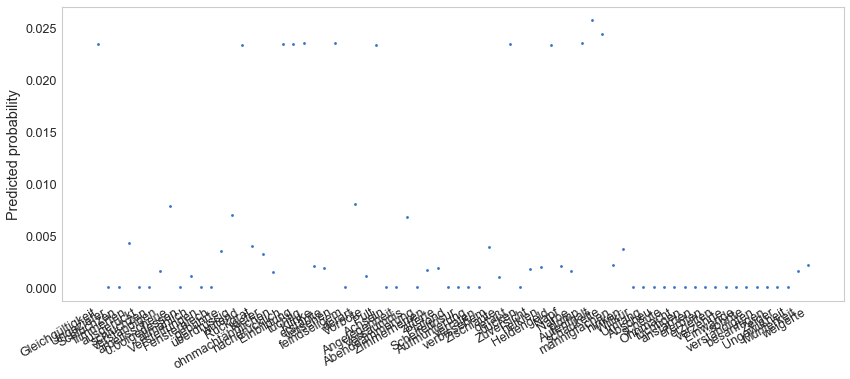

In [8]:
fig = plt.figure(figsize=(14,6))
x = dapstep.delta[dapstep.p_pred < 0.8]
x2 = dapstep.word_ul[dapstep.p_pred < 0.8]
y = dapstep.p_pred[dapstep.p_pred < 0.8]


plt.plot(x2, y, '.')
plt.ylabel('Predicted probability')
plt.gcf().autofmt_xdate()

In [10]:
dapstep[['word_ll', 'word_ul', 'p_pred']]

,word_ll,word_ul,p_pred
0,approved,billigte,0.999900
1,indifference,Gleichgültigkeit,0.023497
2,vermin,Ungeziefer,0.000100
3,sleeves,Ärmel,0.999900
4,sobs,Schluchzen,0.000100
5,flickered,flimmerten,0.004394
6,disengaged,ausgerückt,0.000100
7,sob,schluchzen,0.000100
8,edges,Rändern,0.999900
9,communicate,verständigen,0.001656


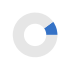

In [19]:
data = [0.1, 1-0.1]
fig, ax = plt.subplots(figsize=(1, 3), subplot_kw=dict(aspect="equal"))

wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=0, colors=['b', '0.9'])


In [15]:
Nwords

103

In [34]:
Nwords = 16
nrows = int(np.sqrt(Nwords)) 
ncols = int( np.ceil(Nwords/ nrows)) 

nrows, ncols, Nwords <= nrows * ncols

(4, 4, True)

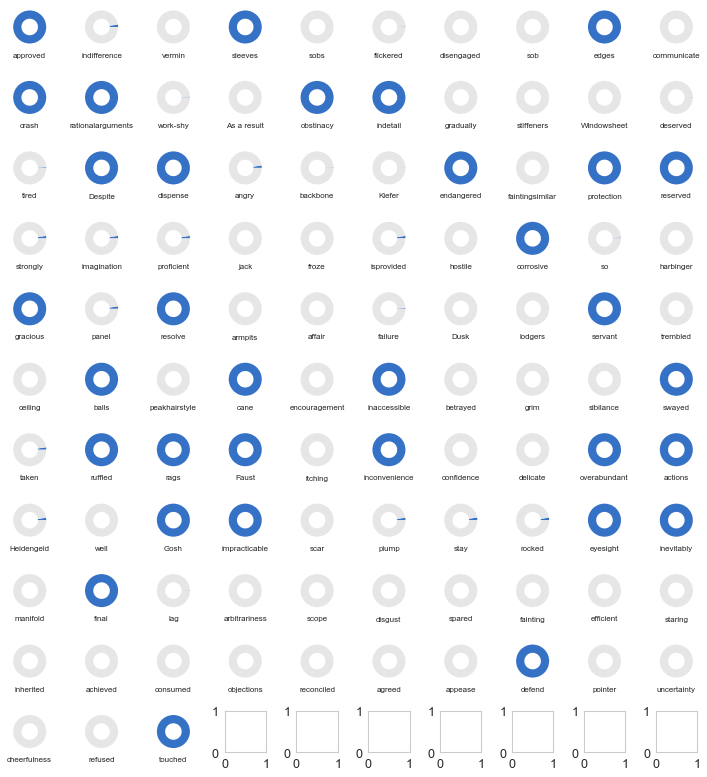

In [12]:
Nwords = len(dapstep)
nrows = int(np.sqrt(Nwords)) 
ncols = int( np.ceil(Nwords/ nrows)) 

fig, ax = plt.subplots(nrows, ncols, figsize=(10, nrows))#, subplot_kw=dict(aspect="equal"))
for i, (w,p) in enumerate(zip(dapstep.word_ll, dapstep.p_pred)):
    j, k = i//ncols, i%ncols
    wedges, texts = ax[j,k].pie([p, 1-p], wedgeprops=dict(width=0.5), startangle=0, colors=['b', '0.9'])
    ax[j,k].set_xlabel(w, fontsize=8)
plt.tight_layout()